# Importing Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import color
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
import multiprocessing
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

## Preprocessing

In [2]:
# Check cpu count
multiprocessing.cpu_count()
DEVICE = 'cuda'

### Loading data

In [3]:
base_data_dir = pathlib.Path('FloodNet-Supervised_v1.0/')
train_dir = base_data_dir/'train'
test_dir = base_data_dir/'test'
valid_dir = base_data_dir/'val'
train_img_dir, train_mask_dir = train_dir/'train-org-img', train_dir/'train-label-img'
valid_img_dir, valid_mask_dir = valid_dir/'valid-org-img', valid_dir/'valid-label-img'
test_img_dir, test_mask_dir = test_dir/'test-org-img', test_dir/'test-label-img'

In [4]:
# Fetching all the jpgs from the img folder
# the glob module is used to retrieve files/pathnames matching a specified pattern
train_images = list(train_img_dir.glob('*.jpg'))
valid_images = list(valid_img_dir.glob('*.jpg'))
test_images = list(test_img_dir.glob('*.jpg'))
print(f"No of Train Images: {len(train_images)}, No of Valid Images: {len(valid_images)}, No of Test Images: {len(test_images)}")
train_images[:5]

No of Train Images: 1445, No of Valid Images: 0, No of Test Images: 448


[WindowsPath('FloodNet-Supervised_v1.0/train/train-org-img/10165.jpg'),
 WindowsPath('FloodNet-Supervised_v1.0/train/train-org-img/10166.jpg'),
 WindowsPath('FloodNet-Supervised_v1.0/train/train-org-img/10168.jpg'),
 WindowsPath('FloodNet-Supervised_v1.0/train/train-org-img/10170.jpg'),
 WindowsPath('FloodNet-Supervised_v1.0/train/train-org-img/10171.jpg')]

In [5]:
def label_mask_path(mask_dir, image_path):
    return mask_dir/f'{image_path.stem}_lab.png'
idx = 42
img_path = train_images[idx]
label_path = label_mask_path(train_mask_dir, img_path)
print(img_path)
print(label_path)

FloodNet-Supervised_v1.0\train\train-org-img\6341.jpg
FloodNet-Supervised_v1.0\train\train-label-img\6341_lab.png


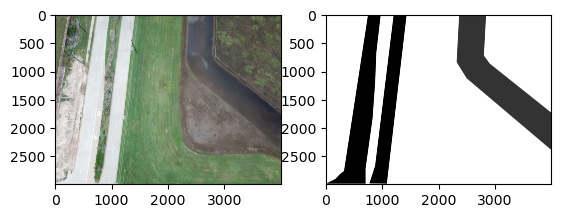

In [6]:
plt.subplot(121)
img = Image.open(img_path)
img = np.asarray(img)
plt.imshow(img)
plt.subplot(122)
mask = Image.open(label_path)
mask = np.asarray(mask)
plt.imshow(mask, cmap = 'gray');

In [26]:
unique_labels = []
for img in tqdm(train_images):
    mask_path = label_mask_path(train_mask_dir, img)
    mask = np.asarray(Image.open(mask_path))
    unique_label = np.unique(mask).tolist()
    unique_labels.extend(unique_label)
print(f"No of unique labels: {len(set(unique_labels))}")

100%|██████████| 1445/1445 [08:48<00:00,  2.73it/s]

No of unique labels: 10


In [7]:
class SatelliteDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, images, transforms = None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
         
    def __getitem__(self, idx):
        current_img_path = self.images[idx]
        current_label_path = self.label_mask_path(current_img_path)
        img = np.asarray(Image.open(current_img_path)).copy()
        mask = np.asarray(Image.open(current_label_path)).copy()
        if self.transforms:
            transformed = self.transforms(image = img, mask = mask)
            img = transformed['image']
            mask = transformed['mask']
        return img, mask

    def label_mask_path(self, image_path):
        return self.masks_dir/f'{image_path.stem}_lab.png'

In [8]:
train_augmentation = A.Compose([# A.LongestMaxSize(max_size=1024, interpolation=1),
                                A.RandomCrop(height = 512, width = 512),
                                ToTensorV2(),
                                ])
train_dataset = SatelliteDataset(train_img_dir, train_mask_dir, train_images, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = 4, shuffle=True)

In [9]:
print('No. of batches in train loader = ',len(trainloader))
print ('Size of training dataset = ',len(train_dataset) )

No. of batches in train loader =  362
Size of training dataset =  1445


In [10]:
test_augmentation = A.Compose([A.RandomCrop(height=512,width=512),ToTensorV2()])
test_dataset = SatelliteDataset(test_img_dir, test_mask_dir, test_images, test_augmentation)
testloader = DataLoader(test_dataset, batch_size=4)

In [11]:
print ('No. of batches in test loader = ',len(testloader))
print ('Size of training dataset = ',len(test_dataset) )

No. of batches in test loader =  112
Size of training dataset =  448


In [12]:
train_imgs, train_masks = next(iter(trainloader))
train_imgs.shape, train_masks.shape

(torch.Size([4, 3, 512, 512]), torch.Size([4, 512, 512]))

In [13]:
test_imgs, test_masks = next(iter(testloader))
test_imgs.shape, test_masks.shape

(torch.Size([4, 3, 512, 512]), torch.Size([4, 512, 512]))

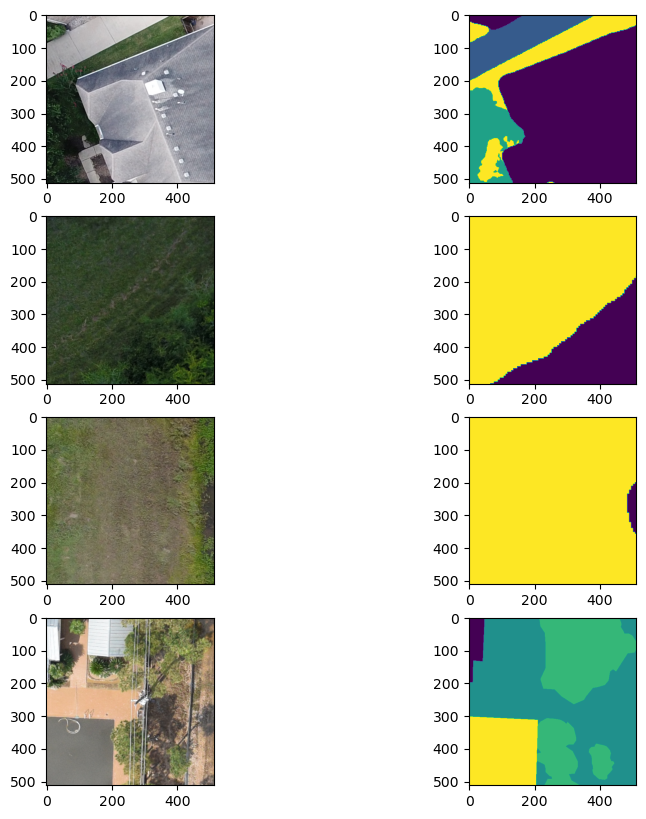

In [14]:
fig, axes = plt.subplots(4, 2, figsize = (10,10))
for i in range(4):
    # (H x W x C) -> (C x H x W)
    img, mask = np.transpose(train_imgs[i].cpu().detach(), (1,2,0)), train_masks[i]
    axes[i, 0].imshow(img)
    #axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    #axes[i, 1].axis('off')

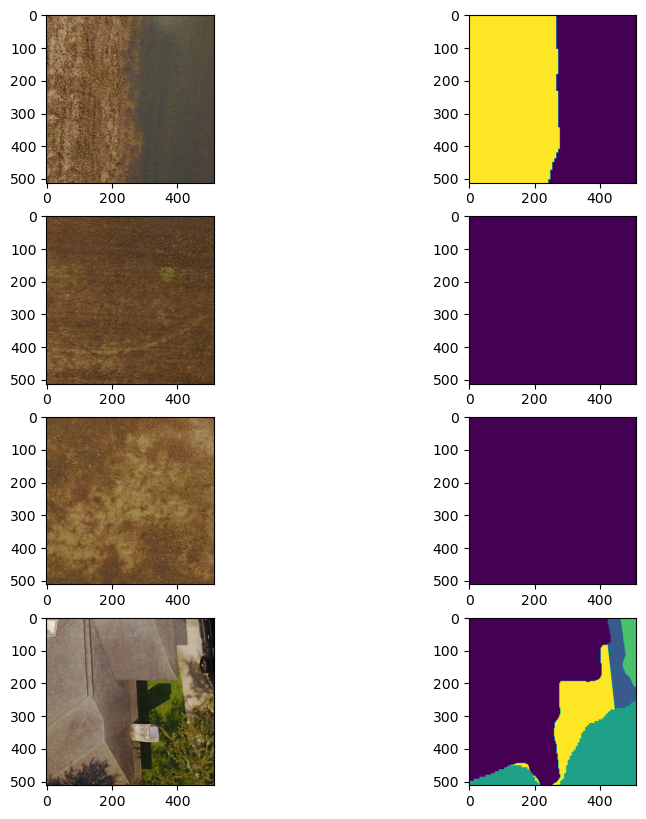

In [15]:
fig, axes = plt.subplots(4, 2, figsize = (10,10))
for i in range(4):
    # (H x W x C) -> (C x H x W)
    img, mask = np.transpose(test_imgs[i].cpu().detach(), (1,2,0)), test_masks[i]
    axes[i, 0].imshow(img)
    #axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    #axes[i, 1].axis('off')

In [16]:
for img,mask in (trainloader):
    break
print ("For one batch \nImage Shape = ",img.shape)
print ("Mask shape = ",mask.shape)

For one batch 
Image Shape =  torch.Size([4, 3, 512, 512])
Mask shape =  torch.Size([4, 512, 512])


### Segmentation Model

In [17]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()
        self.arc = smp.Unet(encoder_name = 'resnet34', encoder_weights = 'imagenet', classes = 10)

    def forward(self, images, masks = None):
        logits = self.arc(images)
        if masks != None:
            Loss = DiceLoss(mode = 'multiclass',classes=10)(logits,masks)
            return logits,Loss
        return logits

In [18]:
model = SegmentationModel()
model.to(DEVICE);

### Train and Test Function 

In [19]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    for imgs,masks in tqdm(data_loader):
        imgs = imgs.to(DEVICE).type(torch.float32)
        masks = masks.to(DEVICE).type(torch.float32)
        optimizer.zero_grad()
        logits,loss = model(imgs,masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [20]:
def test_fn(data_loader, model):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for imgs,masks in tqdm(data_loader):
            imgs = imgs.to(DEVICE).type(torch.float32)
            masks = masks.to(DEVICE).type(torch.float32)
            logits,loss = model(imgs,masks)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

### Hyperparameters

In [21]:
learning_rate = 0.003
num_epochs = 2 

### Optimiser

In [22]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

### Training model

In [23]:
best_test_loss = np.Inf
for i in range(num_epochs):
    train_loss = train_fn (trainloader, model, optimizer)
    test_loss = test_fn (testloader, model)
    if test_loss < best_test_loss:
        torch.save(model.state_dict(),'Best Model.pt')
        print("Model Saved")
        best_test_loss = test_loss
    print (f"Epoch : {i+1} Train Loss = {train_loss} Test Loss = {test_loss}")

  0%|          | 0/362 [00:07<?, ?it/s]


RuntimeError: one_hot is only applicable to index tensor.